In [1]:
import gmsh
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(14,7))
plt.rc('axes',labelsize=24)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
import numpy as np

In [2]:
gmsh.initialize()

Info    : Increasing process stack size (8192 kB < 16 MB)


 aunque vallamos a poner los elementos a mano, necesitamos generar la superficie para asignarlos:

In [3]:
lc = 1
L = 10
modelname = 'chapa-asym'
gmsh.model.add(modelname)
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc/5)
p2 = gmsh.model.geo.addPoint(0, L, 0, lc/5)
p3 = gmsh.model.geo.addPoint(2*L, L, 0, lc) 
p4 = gmsh.model.geo.addPoint(2*L, 0, 0, lc) 

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

S1 = gmsh.model.geo.addPlaneSurface([C1])

In [4]:
gmsh.model.geo.synchronize()

In [5]:
Empotrado = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')
Traccionado = gmsh.model.addPhysicalGroup(1, [l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

In [6]:
L = 10
MN = np.array(
[
    [0,0,0],
    [0, L, 0],
    [2*L,L,0 ],
    [2*L,0,0],
]
)
nodetags = np.linspace(1,MN.shape[0], MN.shape[0]).astype(int)

In [7]:
MC = np.array([ [1,3,2], [1,4,3] ])

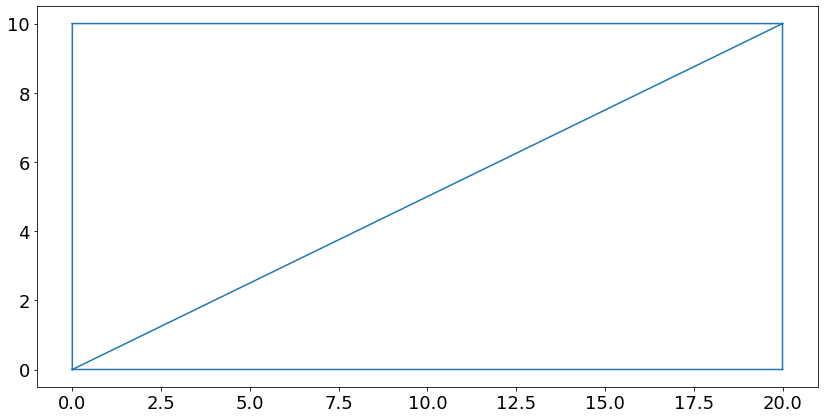

In [8]:
plt.triplot(MN[:,0], MN[:,1], MC-1)

In [9]:
Empotrados = np.array([1,2])
Traccionados = np.array([3,4])

In [10]:
elementags = [[1,2]]

Ponemos el mallado a mano

In [11]:
gmsh.model.mesh.add_nodes(2,S1,nodetags, MN.ravel(),)
gmsh.model.mesh.addElements(2, S1, [2], elementags, [MC.ravel()])
gmsh.model.mesh.add_elements(1,l4, [1], [[len(nodetags)+1]], [Empotrados])
gmsh.model.mesh.add_elements(1,l2, [1], [[len(nodetags)+2]], [Traccionados])

In [12]:
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

In [13]:
gmsh.write('chapa-asym.msh')

Info    : Writing 'chapa-asym.msh'...
Info    : Done writing 'chapa-asym.msh'


In [14]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

In [15]:
import mefmods as mef

In [16]:
ETYPES = 2*np.ones(len(MC)).astype(int)

nu = 0.3

E = 30e6 # 210E9

MP = np.hstack(
        (
            np.ones((len(MC), 1)),
            np.ones((len(MC), 1))*nu,
            np.ones((len(MC), 1))*E
            )
        )

In [17]:
K, Kelem =  mef.ensamble(MC-1, MN-1, MP, 2, ETYPES, 'chapa-asym', return_elementles=True)

In [18]:
K

array([[ 19780219.78,         0.  , -11538461.54,   5769230.77,         0.  , -10714285.71,
         -8241758.24,   4945054.95],
       [        0.  ,  35851648.35,   4945054.95, -32967032.97, -10714285.71,         0.  ,
          5769230.77,  -2884615.38],
       [-11538461.54,   4945054.95,  19780219.78, -10714285.71,  -8241758.24,   5769230.77,
                0.  ,         0.  ],
       [  5769230.77, -32967032.97, -10714285.71,  35851648.35,   4945054.95,  -2884615.38,
                0.  ,         0.  ],
       [        0.  , -10714285.71,  -8241758.24,   4945054.95,  19780219.78,         0.  ,
        -11538461.54,   5769230.77],
       [-10714285.71,         0.  ,   5769230.77,  -2884615.38,         0.  ,  35851648.35,
          4945054.95, -32967032.97],
       [ -8241758.24,   5769230.77,         0.  ,         0.  , -11538461.54,   4945054.95,
         19780219.78, -10714285.71],
       [  4945054.95,  -2884615.38,         0.  ,         0.  ,   5769230.77, -32967032.97,
     

In [19]:
Kelem[0]*0.91/75e3

array([[ 140.,    0.,    0.,  -70., -140.,   70.],
       [   0.,  400.,  -60.,    0.,   60., -400.],
       [   0.,  -60.,  100.,    0., -100.,   60.],
       [ -70.,    0.,    0.,   35.,   70.,  -35.],
       [-140.,   60., -100.,   70.,  240., -130.],
       [  70., -400.,   60.,  -35., -130.,  435.]])

In [20]:
Kelem[1]*0.91/75e3

array([[ 100.,    0., -100.,   60.,    0.,  -60.],
       [   0.,   35.,   70.,  -35.,  -70.,    0.],
       [-100.,   70.,  240., -130., -140.,   60.],
       [  60.,  -35., -130.,  435.,   70., -400.],
       [   0.,  -70., -140.,   70.,  140.,    0.],
       [ -60.,    0.,   60., -400.,    0.,  400.]])

In [21]:
K*0.91/375000

array([[ 48.,   0., -28.,  14.,   0., -26., -20.,  12.],
       [  0.,  87.,  12., -80., -26.,   0.,  14.,  -7.],
       [-28.,  12.,  48., -26., -20.,  14.,   0.,   0.],
       [ 14., -80., -26.,  87.,  12.,  -7.,   0.,   0.],
       [  0., -26., -20.,  12.,  48.,   0., -28.,  14.],
       [-26.,   0.,  14.,  -7.,   0.,  87.,  12., -80.],
       [-20.,  14.,   0.,   0., -28.,  12.,  48., -26.],
       [ 12.,  -7.,   0.,   0.,  14., -80., -26.,  87.]])

In [22]:
s = np.array([0,1,2,3])

In [23]:
r = np.array([4,5,6,7])

In [24]:
U, F = mef.resolvermef(r, s, K, np.array([0,0,0,0]).reshape(-1,1), np.array([50e3,0, 50e3,0]).reshape(-1,1),'chapa-asym')

In [25]:
NumeroNodos, dim = MN.shape

In [26]:
Dxy = U.reshape(NumeroNodos, 2)

In [27]:
Dxyz = np.hstack([Dxy, np.zeros((NumeroNodos, 1))])

In [28]:
NodeInfo = gmsh.model.mesh.get_nodes()

In [29]:
despview = gmsh.view.add('Desplazamientos')
Desp = gmsh.view.addModelData(despview,0,modelname,'NodeData',NodeInfo[0],Dxyz)

In [ ]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


In [ ]:
MN

In [ ]:
Dxyz

In [ ]:
MNdeformada = MN + Dxyz*1e3

In [ ]:
mesh1 = plt.triplot(MN[:,0], MN[:,1], MC-1,label = 'orig')
mesh2 = plt.triplot(MNdeformada[:,0], MNdeformada[:,1], MC-1, label='deformada (x 1e3)')
plt.legend()